# Overview

### For this project we were given data from [IMDB](https://www.imdb.com/), [Box Office Mojo](https://www.boxofficemojo.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/), [TheMovieDB](https://www.themoviedb.org/), and [TheNumbers](https://www.the-numbers.com/). Descriptive analysis of the data reveals that creating a movie within the Sci-Fi genre would allow for the best chance to create a box office hit. (                 ) Our client can use this analysis when deciding which movies to create.

# Business Problem

### Our company is interested in creating a new movie studio to stay competitive, but they do not know anything about creating movies.

### Our goal was to determine which movies are doing best at the box office and make three recommendations for our company to use when deciding what type of films to create

# Data

### To help assist us, we used data from [IMDB](https://www.imdb.com/) and [TheNumbers](https://www.the-numbers.com/). TheNumbers allowed us to look at a movie's budget and gross, while IMDB gave us a look at a movie's genres and director.

### There were certain limitations with the dataset, with IMDB only having current information from 2010-2019 and also having some cases where a movie was missing a genre as it only showed the top three.

# Importing Libraries And Reading in Data

In [160]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.dummy import DummyRegressor
%matplotlib inline

In [161]:
#read in csv file, TheNumbers
df_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz') #5782 x 6, budget, domestic_gross, worldwide_gross from TheNumbers

#read in sql file, IMDB
conn = sqlite3.connect("data/im.db/im.db")
df_imdb = pd.read_sql( #163164 × 4 genres, director from IMDB
    """
    SELECT basic.primary_title as movie_title, basic.start_year as year, basic.genres, persons.primary_name as director
    FROM movie_basics as basic
    JOIN directors
    ON basic.movie_id = directors.movie_id
    JOIN persons
    ON directors.person_id = persons.person_id
    """
, conn
).drop_duplicates()

In [162]:
#new column to track release year to help with the merge, and stop most cases where different movies are merged together
df_movie_budgets["release_year"] = [int(data[-4:]) for data in df_movie_budgets["release_date"]]
#merging TheNumbers and IMDB on movie and year 1700 x 11
df_final = pd.merge(df_movie_budgets, df_imdb, left_on=['movie', 'release_year'], right_on=['movie_title', 'year'])

# Formatting Change and Filtering

In [163]:
#dropped duplicate columns
df_final = df_final.drop(columns=['year', 'movie_title', 'id'])

#removing NA values from genres column
df_final = df_final.loc[df_final["genres"].isna() == False]

#converted string budget and gross to integers to help calculate profit integer
df_final["production_budget_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["production_budget"]]
df_final["worldwide_gross_int"] = [int(budget.strip('$').replace(",", "")) for budget in df_final["worldwide_gross"]]
df_final["profit"] = df_final["worldwide_gross_int"] - df_final["production_budget_int"]

#only look at movies above 100,000,000 profit
df_final = df_final.loc[df_final["profit"] > 100000000]

#five errors happened where a two different movies were merged together(they had the same name and release year)
#the wrong movies were removed based on their genre. The correct movies are still in the dataframe
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Hercules"].loc[df_final["genres"] == "Comedy"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Cinderella"].loc[df_final["genres"] == "Fantasy"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Coco"].loc[df_final["genres"] == "Horror"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "Alice in Wonderland"].loc[df_final["genres"] == "Fantasy,Musical"].index, axis='index')
df_final = df_final.drop(df_final.loc[df_final["movie"] == "The Artist"].loc[df_final["genres"] == "Thriller"].index, axis='index')

In [167]:
top_five_genres = []
#used to seperate movies into their genres and profit. Depending on how many genres a movie has, there will be that many entries
def top_five(genre_name):
    for movie in df_final[["genres", "profit"]].drop_duplicates().values:
        if genre_name in movie[0]:
            top_five_genres.append([genre_name, movie[1]])
            
#picked 5 genres with top profit average and top counts. All genres are in the appendix
top_five("Action")
top_five("Adventure")
top_five("Animation") 
top_five("Comedy")
top_five("Sci-Fi")

df_genres = pd.DataFrame(top_five_genres, columns=["Genre", "Profit"])

# Exploratory Data Analysis

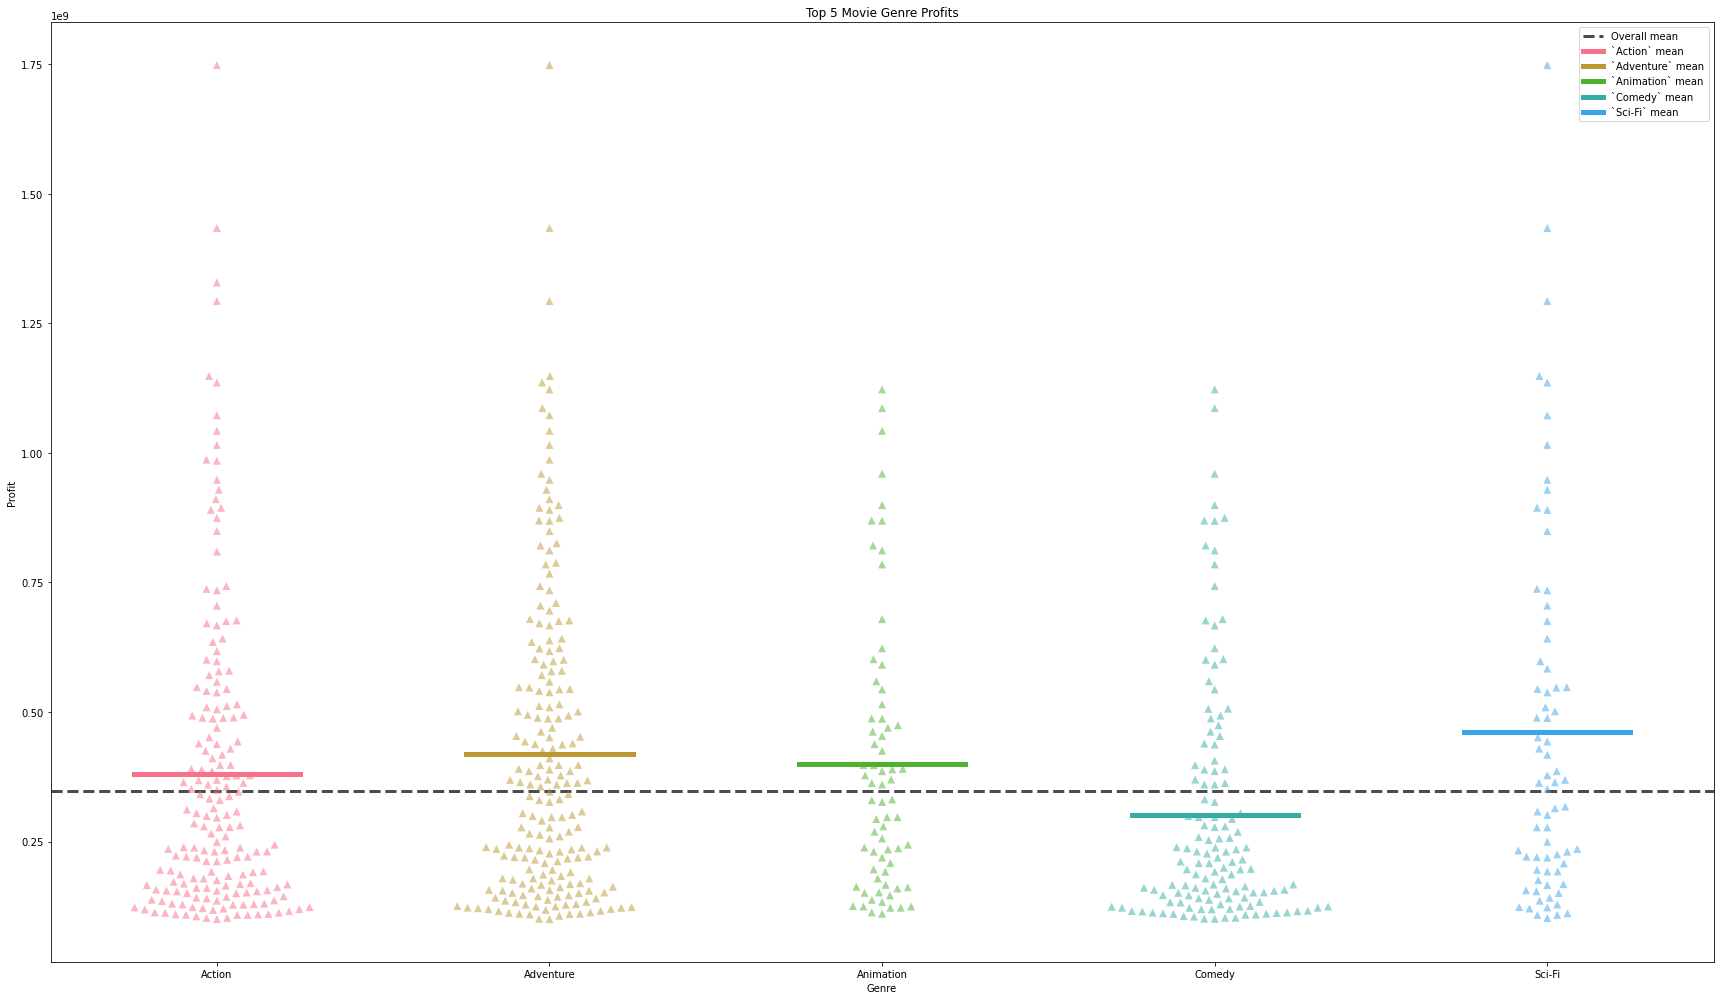

In [168]:
#anova with the top 5 genres and their profits
f, ax = plt.subplots(figsize=(24,14))
# Use specific set of colors
colors = sns.color_palette('husl')

# Data Points
ax = sns.swarmplot(
    data=df_genres,
    x="Genre",
    y="Profit",
    ax=ax,
    alpha=0.5, 
    marker='^',
    size=8,
    palette=colors
)

ax.axhline(
    df_final["profit"].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

areas = df_genres['Genre'].unique()
for i,area in enumerate(areas):
    mean = df_genres.loc[df_genres['Genre']==area]['Profit'].mean()
    # Make these lines short and near each group
    xmin = 1/len(areas) * i + 0.05
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{area}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
plt.title("Top 5 Movie Genre Profits")
ax.legend()
plt.tight_layout();

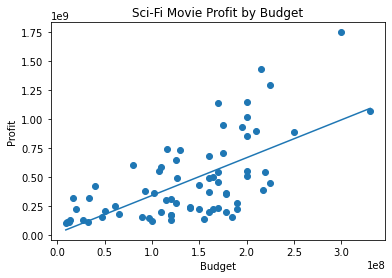

In [169]:
#sci-fi movie profit by budget linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.xlabel("Budget")
plt.ylabel("Profit")
plt.title("Sci-Fi Movie Profit by Budget")
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

In [123]:
df_scifi = pd.DataFrame([movie for movie in df_final[["movie", "director", "genres", "production_budget_int", "profit"]]
                         .values if "Sci-Fi" in movie[2]], 
                        columns=["movie", "director", "genres", "budget", "profit"])
df_budget_profit = df_scifi[["budget", "profit"]].drop_duplicates()
x = list(df_budget_profit["budget"])
y = list(df_budget_profit["profit"])
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x, y)
dummy_regr.score(x, y)

0.0

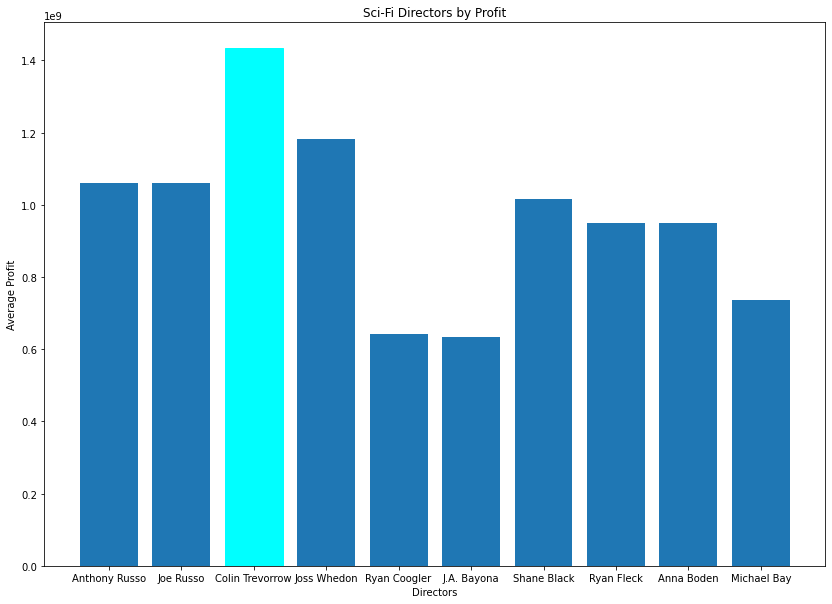

In [170]:
#dictionairy to track top 10 sci-fi directors and the average of the movies they have created
director_scifi = {director : math.ceil(df_final.loc[df_final["director"] == director]["profit"].mean()) 
                  for director in df_scifi.sort_values(by=["profit"], ascending=False)["director"]
                  .drop_duplicates().head(10)}
director_scifi
fig = plt.figure(figsize = (14, 10))
bar = plt.bar(director_scifi.keys(), director_scifi.values())
plt.title("Sci-Fi Directors by Profit")
plt.xlabel("Directors")
plt.ylabel("Average Profit")
bar[2].set_color('cyan')
plt.show()

In [146]:
df_final[df_final["director"] == "Colin Trevorrow"]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,runtime_minutes,genres,director,production_budget_int,worldwide_gross_int,profit
27,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864",2015,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow,215000000,1648854864,1433854864


# Write to File

# Appendix

In [173]:
#since we choose to look at a movie's profit to decide on a movie's success, we decided to only look at TheNumbers
#as either the other data sources didnt include budget and gross or had less data than TheNumbers
df_movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz') #3387 x 5 domestic_gross, foreign_gross, year from
df_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t') #1560 x 12 rating, genre, director, writer, box office, runtime from Rotten Tomatoes
df_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape') #54432 x 8 rating, fresh, top critic from Rotten tomatoes
df_movies = pd.read_csv('data/tmdb.movies.csv.gz') #26517 x 10 popularity, vote_average, vote_count #from TheMoviesTB
#df_directors = pd.read_sql(
   # """
    #Select persons.primary_name, persons.primary_profession, movie_basics.primary_title
    #FROM directors
    #JOIN persons
    #ON directors.person_id = persons.person_id
    #JOIN movie_basics
    #ON movie_basics.movie_id = directors.movie_id
    #"""
#, conn
#)
#df_persons = pd.read_sql(
    #"""
    #SELECT *
    #FROM known_for
    #JOIN persons
    #ON known_for.person_id = persons.person_id
    #"""
#, conn
#)

In [187]:
#Some findings we made throughout the project

#Something we noticed is that Avatar is not a part of the IMDB data, 
#which is very suprising as its either the top or second highest profitable movie. It came out in 2009.
df_imdb[df_imdb["director"] == "James Cameron"]

,movie_title,year,genres,director
21501,Avatar 2,2021,"Action,Adventure,Fantasy",James Cameron
31366,Avatar 3,2023,"Action,Adventure,Drama",James Cameron
108965,Avatar 4,2025,"Action,Adventure,Fantasy",James Cameron
205769,Avatar 5,2027,"Action,Adventure,Fantasy",James Cameron


In [188]:
#The data seems to start in 2010 and starts dwindling in 2020
print(df_imdb["year"].value_counts())

2017    19471
2016    19068
2018    18858
2014    17843
2015    17773
2013    16664
2012    15485
2011    14819
2010    13301
2019     8911
2020      873
2021       74
2022       18
2023        2
2027        1
2025        1
2024        1
2115        1
Name: year, dtype: int64


In [190]:
#some movies arent listed with applicable genres, missing SciFi. It takes place in space and the cast is comprised of aliens
df_final.loc[df_final["movie"] == "Guardians of the Galaxy"]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,genres,director,production_budget_int,worldwide_gross_int,profit
90,"Aug 1, 2014",Guardians of the Galaxy,"$170,000,000","$333,172,112","$770,867,516",2014,"Action,Adventure,Comedy",James Gunn,170000000,770867516,600867516


In [191]:
#also interesting that imdb has data from movies that aren't currently out or werent out when the data was taken. 
#This entry actually is correct as the movie is being released in 2115
df_imdb[df_imdb["year"] == 2115]

,movie_title,year,genres,director
193106,100 Years,2115,Drama,Robert Rodriguez


In [193]:
def avg_profit_genre(genre_name):
    genre_combined_profit = 0
    genre_count = 0
    movie_profits = []
    for movie in df_final[["genres", "profit"]].drop_duplicates().values:
        if genre_name in movie[0]:
            if genre_name == "Music" and "Musical" in movie[0]: #makes sure to keep Musical movies out of the Music average
                continue
            movie_profits.append(movie[1])
            genre_combined_profit += movie[1]
            genre_count += 1
    return [genre_name, math.ceil(genre_combined_profit/genre_count), genre_count, movie_profits] 

genre_averages = [avg_profit_genre("Action"), avg_profit_genre("Adventure"), avg_profit_genre("Animation"), 
                avg_profit_genre("Biography"), avg_profit_genre("Comedy"), avg_profit_genre("Crime"), 
                avg_profit_genre("Documentary"), avg_profit_genre("Drama"), avg_profit_genre("Fantasy"),
                avg_profit_genre("Family"), avg_profit_genre("History"), avg_profit_genre("Horror"),
                avg_profit_genre("Music"), avg_profit_genre("Musical"), avg_profit_genre("Mystery"), 
                avg_profit_genre("Sci-Fi"), avg_profit_genre("Thriller"), avg_profit_genre("War"),
                avg_profit_genre("Western")]
df_genres = pd.DataFrame(genre_averages, columns=["Genre", "Average", "Count", "Profits"])
df_genres

,Genre,Average,Count,Profits
0,Action,379421200,179,"[635063875, 1072413963, 1748134200, 355945209,..."
1,Adventure,418484478,198,"[635063875, 1072413963, 1748134200, 355945209,..."
2,Animation,399765177,69,"[326477240, 1042520711, 821215193, 868879522, ..."
3,Biography,224641882,26,"[397938302, 289870414, 302665550, 208346281, 1..."
4,Comedy,301379412,131,"[326477240, 439213485, 821215193, 868879522, 5..."
5,Crime,233587409,36,"[984846267, 1328722794, 505163454, 410663443, ..."
6,Documentary,183994263,4,"[184486852, 255997896, 151685793, 143806510]"
7,Drama,226631231,110,"[112459006, 161040419, 168902025, 787854547, 5..."
8,Fantasy,393035119,44,"[635063875, 355945209, 118151347, 617500281, 7..."
9,Family,367543354,29,"[767003568, 825491110, 290359051, 452220086, 4..."
